In [1]:
import numpy as np
from pythtb import *
# from wanpy.wpythtb import *
# from models import *
import matplotlib.pyplot as plt
from functools import partial
from itertools import product, permutations
from scipy.linalg import eigh
from tensorflow import constant as const
import tensorflow as tf
import tensorflow.linalg as tfla
from tensorflow import complex64
from scipy.integrate import cumulative_simpson

%load_ext line_profiler
%timeit

In [2]:
def fu_kane_mele(t, soc, m, beta):
    # set up Fu-Kane-Mele model
    lat = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
    # lat = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    orb = [[0, 0, 0], [0.25, 0.25, 0.25]]
    model = Model(3, 3, lat, orb, nspin=2)

    h = m*np.sin(beta)*np.array([1,1,1])
    dt = m*np.cos(beta)

    h0 = [0] + list(h)
    h1 = [0] + list(-h)

    model.set_onsite(h0, 0)
    model.set_onsite(h1, 1)

    # spin-independent first-neighbor hops
    for lvec in ([-1, 0, 0], [0, -1, 0], [0, 0, -1]):
        model.set_hop(t, 0, 1, lvec)

    model.set_hop(3*t + dt, 0, 1, [0, 0, 0], mode="add")

    # spin-dependent second-neighbor hops
    lvec_list = ([1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 1, 0], [0, -1, 1], [1, 0, -1])
    dir_list = ([0, 1, -1], [-1, 0, 1], [1, -1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1])
    for j in range(6):
        spin = np.array([0.]+dir_list[j])
        model.set_hop( 1j*soc*spin, 0, 0, lvec_list[j])
        model.set_hop(-1j*soc*spin, 1, 1, lvec_list[j])

    return model

In [3]:
def vel_fd(H_k, mu, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(H_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(H_k, shift=-s, axis=mu)

    v = fd_sum / (dk_mu)
    return v

def berry_curvature(v_k, H_flat, occ_idxs=None, batched=False):
    # evals, evecs = np.linalg.eigh(H_flat)  # (..., n_state), (..., n_state, n_state)

    # tensorflow optimization
    H_flat_tf = const(H_flat, dtype=complex64)
    v_k_tf = const(v_k, dtype=complex64)

    evals_tf, evecs_tf = tfla.eigh(H_flat_tf)
    # evals = evals_tf.numpy()
    # evecs = evecs_tf.numpy()

    # swap for consistent indexing
    evecs_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state)
    evecs_T_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state)
    # evecs_T =  np.swapaxes(evecs, -1, -2)[np.newaxis, ...]
    # evecs = evecs.swapaxes(-1, -2)  

    evecs_conj_tf = tf.math.conj(evecs_tf)
    # evecs_conj = evecs.conj()[np.newaxis, ...]

    # Rotate velocity operators to eigenbasis
    v_k_rot_tf = tf.matmul(
        evecs_conj_tf[None, :, :, :, :],  # (1, n_kpts, n_beta, n_state, n_state)
        tf.matmul(
            v_k_tf,                       # (dim_k, n_kpts, n_beta, n_state, n_state)
            evecs_T_tf[None, :, :, :, :]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    )  # (dim_k, n_kpts, n_beta, n_state, n_state)
    # v_k_rot = np.matmul(evecs_conj, np.matmul(v_k, evecs_T)) # (dim_k, n_kpts, n_state, n_state)

    # print(np.allclose(v_k_rot, v_k_rot_tf.numpy()))
    # print(np.amax(v_k_rot - v_k_rot_tf.numpy()))

    # Identify occupied bands
    n_eigs = evals_tf.shape[-1]
    if occ_idxs is None:
        occ_idxs =  np.arange(n_eigs//2)
    elif occ_idxs == 'all':
        occ_idxs =  np.arange(n_eigs)
    else:
        occ_idxs = np.array(occ_idxs)

    # Identify conduction bands
    cond_idxs = np.setdiff1d(np.arange(n_eigs), occ_idxs)  # Identify conduction bands

    # Compute energy denominators
    delta_E_tf = evals_tf[..., None, :] - evals_tf[..., :, None]
    delta_E_occ_cond_tf = tf.gather(tf.gather(delta_E_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    delta_E_cond_occ_tf = tf.gather(tf.gather(delta_E_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond_tf
    inv_delta_E_cond_occ_tf = 1 / delta_E_cond_occ_tf

    # Compute energy denominators in vectorized way
    # delta_E = evals[..., np.newaxis, :] - evals[..., :, np.newaxis]
    # delta_E_occ_cond = delta_E[..., occ_idxs, :][..., :, cond_idxs]
    # delta_E_cond_occ = delta_E[..., cond_idxs, :][..., :, occ_idxs]
    # inv_delta_E_occ_cond = np.divide(1, delta_E_occ_cond)
    # inv_delta_E_cond_occ = np.divide(1, delta_E_cond_occ)

    # Extract relevant submatrices
    # v_occ_cond = v_k_rot[..., occ_idxs, :][..., :, cond_idxs]
    # v_cond_occ = v_k_rot[..., cond_idxs, :][..., :, occ_idxs]
    # v_occ_cond = v_occ_cond * inv_delta_E_occ_cond
    # v_cond_occ = v_cond_occ * inv_delta_E_cond_occ

    # Initialize Berry curvature
    # b_curv = 1j * ( 
    #     np.matmul(v_occ_cond[:, None], v_cond_occ[None, :]) 
    #     - np.matmul(v_occ_cond[None, :], v_cond_occ[:, None])
    # )
    # Compute the matrix products as real-valued tensors

    v_occ_cond_tf = tf.gather(tf.gather(v_k_rot_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    v_cond_occ_tf = tf.gather(tf.gather(v_k_rot_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    v_occ_cond_tf = v_occ_cond_tf * inv_delta_E_occ_cond_tf
    v_cond_occ_tf = v_cond_occ_tf * -inv_delta_E_cond_occ_tf

    # Compute Berry curvature
    b_curv_tf = 1j * (
        tf.matmul(v_occ_cond_tf[:, None], v_cond_occ_tf[None, :]) -
        tf.matmul(v_occ_cond_tf[None, :], v_cond_occ_tf[:, None])
    )

    # # Convert final result to NumPy
    b_curv = b_curv_tf.numpy()

    return b_curv

In [4]:
def compute_d4k_and_d2k(delta_k):
    """
    Computes the 4D volume element d^4k and the 2D plaquette areas d^2k for a given set of difference vectors in 4D space.

    Parameters:
    delta_k (numpy.ndarray): A 4x4 matrix where each row is a 4D difference vector.

    Returns:
    tuple: (d4k, plaquette_areas) where
        - d4k is the absolute determinant of delta_k (4D volume element).
        - plaquette_areas is a dictionary with keys (i, j) and values representing d^2k_{ij}.
    """
    # Compute d^4k as the determinant of the 4x4 difference matrix
    d4k = np.abs(np.linalg.det(delta_k))

    # Function to compute 2D plaquette area in 4D space
    def compute_plaquette_area(v1, v2):
        """Compute the 2D plaquette area spanned by two 4D vectors."""
        # area_squared = 0.0
        # # Sum over all unique (m, n) pairs where m < n
        # for m in range(4):
        #     for n in range(m + 1, 4):
        #         area_squared += (v1[m] * v2[n] - v1[n] * v2[m]) ** 2
        # return np.sqrt(area_squared)
        A = np.vstack([v1, v2])
        return np.sqrt(np.linalg.det(A @ A.T))

    # Compute all unique plaquette areas
    plaquette_areas = {}
    for i in range(4):
        for j in range(i + 1, 4):
            plaquette_areas[(i, j)] = compute_plaquette_area(delta_k[i], delta_k[j])

    return d4k, plaquette_areas

In [5]:
########## Model #############

# Reference Model
t = 0     # spin-independent first-neighbor hop
soc = 0   # spin-dependent second-neighbor hop
m = 0     # magnetic field magnitude
beta = 0  # Adiabatic parameter
fkm_model = fu_kane_mele(t, soc, m, beta)

# Model generator for a set of fixed parameters
fixed_params = {"t": 1.0, "soc": 1/4, "m": 1/2}
model_gen = partial(fu_kane_mele, **fixed_params)

# Varying parameter space
nks = 20, 20, 30
n_beta = 120
k_flat = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=False) for nk in nks])))
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic
lambda_vals = {"beta": betas}

########### Useful model information ###########
recip_lat_vecs = fkm_model.get_recip_lat_vecs()  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.n_spin   # Number of spins
n_orb = fkm_model.n_orb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions 
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_spin}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)

print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))

NameError: name 'Model' is not defined

In [ ]:
####### kappa (q) internal differentials ########
dq = np.zeros((dim_total, dim_total)) 
np.fill_diagonal(dq[:dim_k, :dim_k], 1 / np.array(nks))
np.fill_diagonal(dq[dim_k:, dim_k:], 1 / np.array(n_beta))
d4q = np.linalg.det(dq)

print("dq vectors: \n", dq)
print("d^4q =", d4q)
print()
###### For integration in Cartesian space #######

# Total matrix of lattice vectors
basis_4space = np.zeros((dim_total, dim_total))
basis_4space[:dim_k, :dim_k] = recip_lat_vecs
np.fill_diagonal(basis_4space[dim_k:, dim_k:], 2*np.pi)

# Metric for the adiabatic parameter space 
g4 = basis_4space @ basis_4space.T
sqrt_mtrc = np.sqrt(np.linalg.det(g4))
d4k = sqrt_mtrc * d4q

print(f"basis vectors: B = \n {basis_4space}")
print(f"Metric: g = BB^T = \n{g4}")
print(f"det(B) = sqrt(|g|) = {np.linalg.det(basis_4space)} = {sqrt_mtrc}")
print(f"d^4k = sqrt(|g|) d^4q = {d4k}")
print()

# Angle information
unit_4space = basis_4space / np.linalg.norm(basis_4space, axis=1, keepdims=True)
g4_unit = unit_4space @ unit_4space.T
sqrt_mtrc_unit = np.sqrt(np.linalg.det(g4_unit))
print(f"g_unit = \n{g4_unit}")
print(f"sqrt(|g_unit|) = {sqrt_mtrc_unit}\n")

dq vectors: 
 [[0.05       0.         0.         0.        ]
 [0.         0.05       0.         0.        ]
 [0.         0.         0.03333333 0.        ]
 [0.         0.         0.         0.00833333]]
d^4q = 6.944444444444444e-07

basis vectors: B = 
 [[-3.14159265  3.14159265  3.14159265  0.        ]
 [ 3.14159265 -3.14159265  3.14159265  0.        ]
 [ 3.14159265  3.14159265 -3.14159265  0.        ]
 [ 0.          0.          0.          6.28318531]]
Metric: g = BB^T = 
[[29.6088132 -9.8696044 -9.8696044  0.       ]
 [-9.8696044 29.6088132 -9.8696044  0.       ]
 [-9.8696044 -9.8696044 29.6088132  0.       ]
 [ 0.         0.         0.        39.4784176]]
det(B) = sqrt(|g|) = 779.272728272019 = 779.272728272019
d^4k = sqrt(|g|) d^4q = 0.0005411616168555687

g_unit = 
[[ 1.         -0.33333333 -0.33333333  0.        ]
 [-0.33333333  1.         -0.33333333  0.        ]
 [-0.33333333 -0.33333333  1.          0.        ]
 [ 0.          0.          0.          1.        ]]
sqrt(|g_unit|

In [ ]:
delta_k = recip_lat_vecs / np.array(nks)[:, None] 
dk1 = np.linalg.norm(delta_k[0])
dk2 = np.linalg.norm(delta_k[1])
dk3 = np.linalg.norm(delta_k[2])
d_beta = max_beta / n_beta  # Step size for beta integration

# Construct delta_k with 4D embedding (extra zeros for adiabatic params)
dk = np.zeros((dim_total, dim_total)) 
dk[:dim_k, :dim_k] = delta_k #recip_lat_vecs / np.array(nks)[:, None]
np.fill_diagonal(dk[dim_k:, dim_k:], d_beta)

d3k = np.linalg.det(delta_k)
d4k = np.linalg.det(dk)
d4k_, d2ks = compute_d4k_and_d2k(dk) 
d3k_alt = np.prod([dk1, dk2, dk3])
d4k_alt = np.prod([dk1, dk2, dk3, d_beta])

print("dk vectors in 3d BZ: \n", delta_k)
print("dk vectors in 4d: \n", dk)
print()
print("d4k =", d4k)
print("d3k =", d3k)
print()
print(f"dk1 = {dk1}, dk2 = {dk2}, dk3 = {dk3}, d_beta = {d_beta}")
print(f"dk1*dk2 = {dk1*dk2}")
print(f"dk1*dk2*dk3 = {d3k_alt}")
print(f"dk1*dk2*dk3*d_beta = {d4k_alt}")

print()
print("Plaquette Areas (d^2k):")
for key, value in d2ks.items():
    print(f"d^2k_{key} = {value}")

dk vectors in 3d BZ: 
 [[-0.15707963  0.15707963  0.15707963]
 [ 0.15707963 -0.15707963  0.15707963]
 [ 0.10471976  0.10471976 -0.10471976]]
dk vectors in 4d: 
 [[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.15707963 -0.15707963  0.15707963  0.        ]
 [ 0.10471976  0.10471976 -0.10471976  0.        ]
 [ 0.          0.          0.          0.05235988]]

d4k = 0.0005411616168555687
d3k = 0.010335425560099932

dk1 = 0.2720699046351327, dk2 = 0.2720699046351327, dk3 = 0.18137993642342176, d_beta = 0.05235987755982988
dk1*dk2 = 0.0740220330081702
dk1*dk2*dk3 = 0.013426111640954337
dk1*dk2*dk3*d_beta = 0.0007029895616249758

Plaquette Areas (d^2k):
d^2k_(0, 1) = 0.06978864199638879
d^2k_(0, 2) = 0.04652576133092585
d^2k_(0, 3) = 0.014245546894410143
d^2k_(1, 2) = 0.04652576133092585
d^2k_(1, 3) = 0.014245546894410143
d^2k_(2, 3) = 0.009497031262940093


## Using Kubo

In [ ]:
v_k = np.zeros((fkm_model.dim_k, k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)
H_kbeta = np.zeros((k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)

for idx, beta in enumerate(betas):
    print(idx)
    fkm_model_fxd = model_gen(beta=beta)

    H = fkm_model_fxd.get_ham(k_flat)
    v = fkm_model_fxd.gen_velocity(k_flat)

    # flatten spin
    new_shape = (H.shape[0],) + (n_spin*n_orb, n_spin*n_orb)
    H = H.reshape(*new_shape) 
    new_shape = (v.shape[:2]) + (n_spin*n_orb, n_spin*n_orb)
    v = v.reshape(*new_shape)
    
    H_kbeta[:, idx, ...] = H
    v_k[:, :, idx, ...] = v

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [ ]:
v_beta = vel_fd(H_kbeta, mu=1, dk_mu=np.linalg.norm(dq[-1]), order_eps=9)
v = np.concatenate((v_k, v_beta[np.newaxis, ...]), axis=0)

In [ ]:
b_curv_kubo = berry_curvature(v, H_kbeta)

In [ ]:
epsilon = levi_civita(4, 4)
chern2_density_kubo = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv_kubo, b_curv_kubo)

In [ ]:
C2_kubo = np.sum(chern2_density_kubo) * (d4q) / (32 * np.pi**2)
print("C2 from Kubo: ", C2_kubo.real)

C2 from Kubo:  1.020064979121238


In [13]:
dtheta = np.sum(chern2_density_kubo, axis=(0)) 
thetas_kubo = np.cumsum(dtheta) * d4q / (16 * np.pi)

Including endpoints

In [14]:
chern2_dens_mesh = chern2_density_kubo.reshape(*nks, n_beta)
chern2_dens_mesh_ep = np.pad(chern2_dens_mesh, pad_width=((0,1), (0,1), (0,1), (0,1)), mode='wrap')

dtheta_ep = np.sum(chern2_dens_mesh_ep, axis=(0,1,2)) 
thetas_kubo_ep = np.cumsum(dtheta_ep) * d4q / (16 * np.pi)

In [15]:
C2_kubo_ep = np.sum(chern2_dens_mesh_ep) * (d4q) / (32 * np.pi**2)
print("C2 from Kubo (with endpoints): ", C2_kubo_ep.real)

C2 from Kubo (with endpoints):  1.0346101203498668


Simpson

In [16]:
from scipy.integrate import simpson

int_q1 = simpson(chern2_dens_mesh, axis=-2, dx=1/nks[0])
int_q2 = simpson(int_q1, axis=-2, dx=1/nks[1])
int_q3 = simpson(int_q2, axis=-2, dx=1/nks[2])
int_beta = simpson(int_q3, axis=-1, dx=1/n_beta)
c2_simp_kubo = int_beta / (32 * np.pi**2)

thetas_kubo_simp = cumulative_simpson(int_q3.real / (16 * np.pi), dx=1/n_beta, initial=0)
print(f"C2 from Kubo + Simpson: {c2_simp_kubo.real}")

int_q1 = simpson(chern2_dens_mesh_ep, axis=-2, dx=1/nks[0])
int_q2 = simpson(int_q1, axis=-2, dx=1/nks[1])
int_q3 = simpson(int_q2, axis=-2, dx=1/nks[2])
int_beta = simpson(int_q3, axis=-1, dx=1/n_beta)
c2_simp_kubo_ep = int_beta / (32 * np.pi**2)

thetas_kubo_simp_ep = cumulative_simpson(int_q3.real / (16 * np.pi), dx=1/n_beta, initial=0)
print(f"C2 from Kubo + Simpson + ep: {c2_simp_kubo_ep.real}")

C2 from Kubo + Simpson: 0.9171171932093435
C2 from Kubo + Simpson + ep: 0.9294022523522274


## Using Plaquette

In [17]:
bloch_states = Bloch(fkm_model, *n_param)
bloch_states.solve_model(model_fxn=model_gen, lambda_vals=lambda_vals)
bloch_states.set_pbc_lam()

u_wfs = bloch_states.get_states()["Cell periodic"]
n_occ = bloch_states._n_states//2

print(f"Max beta = {max_beta} \nBloch periodic? {bloch_states.pbc_lam}")
print("Shape of wf array:", u_wfs.shape)
print(bloch_states.get_wf_axes())
print("Number of states:", bloch_states._n_states)
print("Number of occupied bands:", n_occ)

AttributeError: 'Model' object has no attribute '_nsta'

In [ ]:
factor = (d4k/(d2ks[0,1]*d2ks[2, 3]))
print(factor)

In [ ]:
# %lprun -f bloch_states.berry_flux_plaq bloch_states.berry_flux_plaq(state_idx=list(range(n_occ)), non_abelian=True)
b_curv, b_flux = bloch_states.berry_curv(state_idx=list(range(n_occ)), non_abelian=True, delta_lam=max_beta, return_flux=True)

In [ ]:
chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv) 

In [ ]:
chern2 = np.sum(chern2_density) * (d4k_alt) / (32 * np.pi**2)
print("C2:", chern2.real)

In [ ]:
chern2_density_flux = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_flux, b_flux) 

In [ ]:
chern2_flux = np.sum(chern2_density_flux) / (32 * np.pi**2)
print("C2:", chern2_flux.real)

In [ ]:
chern2_flux*factor

In [ ]:
thetas_curv = np.zeros(betas.shape[0], dtype=complex)
thetas_flux = np.zeros(betas.shape[0], dtype=complex)

for beta_idx, beta in enumerate(betas):
    sliced_dtheta = chern2_density[..., :beta_idx+1]
    sliced_dtheta_flux = chern2_density_flux[..., :beta_idx+1]
    
    theta = np.sum(sliced_dtheta) 
    theta_flux = np.sum(sliced_dtheta_flux) 
    
    # thetas_curv[beta_idx] = theta * (d4k) / (16 * np.pi)
    thetas_curv[beta_idx] = theta * (d4k) / (16 * np.pi)
    thetas_flux[beta_idx] = theta_flux / (16 * np.pi)

# Plotting

In [ ]:
thetas_kubo = np.load("data/thetas_kubo_40_40_40_120.npy")
thetas_kubo_simp = np.load("data/thetas_kubo_simp_40_40_40_120.npy" )
thetas_kubo_ep = np.load("data/thetas_kubo_simp_ep_40_40_40_120.npy" )
thetas_curv = np.load("data/thetas_curv_40_40_40_120.npy" )
thetas_flux = np.load("data/thetas_flux_40_40_40_120.npy")

Text(0.5, 1.0, 'number of parameters: (20, 20, 30, 120)')

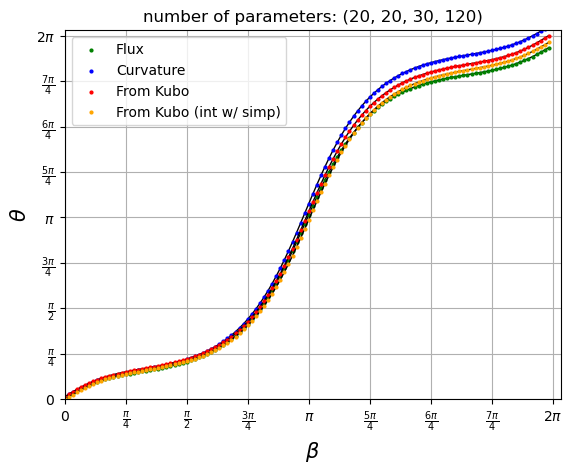

In [ ]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_ylim(0, 2*np.pi+0.1)
ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

### Flux
ax.plot(betas, thetas_flux.real, lw=1, zorder=2, c='k')  
# ax.scatter(betas, thetas_flux.real * (factor/sqrt_mtrc_unit), s=4, zorder=2, c='g', label='Flux')
ax.scatter(betas, thetas_flux.real, s=4, zorder=2, c='g', label='Flux')

### Curvature
ax.plot(betas, thetas_curv.real / sqrt_mtrc_unit, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_curv.real / sqrt_mtrc_unit, s=4, zorder=2, c='b', label='Curvature')
# ax.scatter(betas, thetas_curv.real, s=4, zorder=2, c='b', label='Curvature')

### Riemann sum
ax.plot(betas, thetas_kubo.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_kubo.real, s=4, zorder=2, c='r', label='From Kubo')

### Simpson
ax.plot(betas, thetas_kubo_simp.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_kubo_simp.real, s=4, zorder=2, c='orange', label='From Kubo (int w/ simp)')

### Endpoints
betas_ep = np.linspace(0, 2*np.pi, n_beta+1, endpoint=True)
# ax.plot(betas_ep, thetas_kubo_ep.real, lw=1, zorder=2, c='k')  
# ax.scatter(betas_ep, thetas_kubo_ep.real, s=4, zorder=2, c='orange', label='From Kubo (w/ endpts)')
# ax.plot(betas_ep, thetas_kubo_simp_ep.real, lw=1, zorder=2, c='k')  
# ax.scatter(betas_ep, thetas_kubo_simp_ep.real, s=4, zorder=2, c='orange', label='From Kubo (int w/ simp and ep)')

ax.grid()
ax.legend()
ax.set_title(f"number of parameters: {n_param}")

In [ ]:
40*40*40*120

In [ ]:
np.save("data/thetas_kubo_40_40_40_120.npy", thetas_kubo)
np.save("data/thetas_kubo_simp_40_40_40_120.npy", thetas_kubo_simp)
np.save("data/thetas_kubo_simp_ep_40_40_40_120.npy", thetas_kubo_ep)
np.save("data/thetas_curv_40_40_40_120.npy", thetas_curv)
np.save("data/thetas_flux_40_40_40_120.npy", thetas_flux)